In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
import os
from typing import Dict, List, Tuple, Optional, Any

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import xgboost as xgb

# Set random seed
np.random.seed(42)

In [2]:
df = pd.read_csv("2024_LoL_esports_match_data_from_OraclesElixir.csv")

pd.set_option('display.max_columns', None)
df.head(500)


C:\Users\Jayden\AppData\Local\Temp\ipykernel_8500\1054212567.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("2024_LoL_esports_match_data_from_OraclesElixir.csv")


,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,side,position,playername,playerid,teamname,teamid,champion,ban1,ban2,ban3,ban4,ban5,pick1,pick2,pick3,pick4,pick5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,chemtechs,hextechs,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,gpr,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,goldat20,xpat20,csat20,opp_goldat20,opp_xpat20,opp_csat20,golddiffat20,xpdiffat20,csdiffat20,killsat20,assistsat20,deathsat20,opp_killsat20,opp_assistsat20,opp_deathsat20,goldat25,xpat25,csat25,opp_goldat25,opp_xpat25,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,1,Blue,top,Zika,oe:player:65ed20b21e2993fb00dbd21a2fd991b,LNG Esports,oe:team:a9145b7711873f53e610fbba0493484,Aatrox,Akali,Nocturne,K'Sante,Lee Sin,Wukong,NaN,NaN,NaN,NaN,NaN,1886,0,1,3,1,3,16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0954,0.6045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,225.6204,0.169648,564.1463,NaN,14,0.4454,4,0.1273,5,24,0.7635,11083,6960,221.4210,0.237608,10784,NaN,NaN,279.0,256.0,23,16.0,0.0,8.8759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,2,Blue,jng,Weiwei,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,LNG Esports,oe:team:a9145b7711873f53e610fbba0493484,Maokai,Akali,Nocturne,K'Sante,Lee Sin,Wukong,NaN,NaN,NaN,NaN,NaN,1886,0,0,4,3,3,16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0954,0.6045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7361,234.1782,0.176101,847.4761,NaN,10,0.3181,12,0.3818,10,39,1.2407,8636,4513,143.5737,0.154069,8840,NaN,NaN,153.0,14.0,139,111.0,3.0,4.8674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,3,Blue,mid,Scout,oe:player:71e79ef80600d398d90cfebe3b0b758,LNG Esports,oe:team:a9145b7711873f53e610fbba0493484,Orianna,Akali,Nocturne,K'Sante,Lee Sin,Wukong,NaN,NaN,NaN,NaN,NaN,1886,0,0,2,0,3,16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0954,0.6045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10005,318.2927,0.239355,432.2163,NaN,4,0.1273,8,0.2545,2,

In [3]:
# Find which minute checkpoint has enough data
# If 25-minute data drops too many rows, try 20 or 15
checkpoints = [25, 20, 15]
min_rows_threshold = 300

for minute in checkpoints:
    cols = [f"golddiffat{minute}", f"xpdiffat{minute}", f"csdiffat{minute}"]
    temp_df = df.dropna(subset=cols)
    if temp_df.shape[0] >= min_rows_threshold:
        df = temp_df
        used_minute = minute
        print(f"Using {used_minute}-minute checkpoint with {df.shape[0]} rows")
        break
else:
    raise ValueError("Not enough complete data at 15, 20, or 25 minutes.")

Using 25-minute checkpoint with 94008 rows


In [4]:
# Create team-level dataset
# Define columns we want to include
team_level_cols = [
    "gameid", "side", "result",
    f"golddiffat{used_minute}", f"xpdiffat{used_minute}", f"csdiffat{used_minute}",
    "teamkills", "teamdeaths", "dragons", "opp_dragons", "barons", "opp_barons", 
    'void_grubs', 'opp_void_grubs', "heralds", "opp_heralds", "towers", "opp_towers",
    "firstblood", "firstdragon", "firstherald", "firsttower"
]

# Filter columns that actually exist in the dataset
existing_cols = [col for col in team_level_cols if col in df.columns]
print(f"Using these columns: {existing_cols}")

# Create  dataframe
team_df = df[existing_cols].drop_duplicates(subset=["gameid", "side"]).copy()

team_df.head()

Using these columns: ['gameid', 'side', 'result', 'golddiffat25', 'xpdiffat25', 'csdiffat25', 'teamkills', 'teamdeaths', 'dragons', 'opp_dragons', 'barons', 'opp_barons', 'void_grubs', 'opp_void_grubs', 'heralds', 'opp_heralds', 'towers', 'opp_towers', 'firstblood', 'firstdragon', 'firstherald', 'firsttower']


,gameid,side,result,golddiffat25,xpdiffat25,csdiffat25,teamkills,teamdeaths,dragons,opp_dragons,barons,opp_barons,void_grubs,opp_void_grubs,heralds,opp_heralds,towers,opp_towers,firstblood,firstdragon,firstherald,firsttower
180,LOLTMNT99_132542,Blue,1,1928.0,1127.0,3.0,20,7,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
185,LOLTMNT99_132542,Red,0,-1928.0,-1127.0,-3.0,7,20,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
192,LOLTMNT99_132665,Blue,1,-2068.0,-638.0,-6.0,31,20,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
197,LOLTMNT99_132665,Red,0,2068.0,638.0,6.0,20,31,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
204,LOLTMNT99_132755,Blue,1,1887.0,2243.0,24.0,24,8,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [5]:
# Create feature matrix and target vector
# 1 if blue team wins, 0 otherwise
# First filter for only Blue side games
blue_team_df = team_df[team_df["side"] == "Blue"]

y = (blue_team_df["result"] == 1).astype(int)

# Drop non-feature columns
X = blue_team_df.drop(columns=["gameid", "side", "result"])

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Blue team win rate: {y.mean():.2%}")

X shape: (7834, 19)
y shape: (7834,)
Blue team win rate: 52.04%


In [6]:
# Define which features are continuous and which are binary
# Define column types
continuous_cols = [
    f"golddiffat{used_minute}", f"xpdiffat{used_minute}", f"csdiffat{used_minute}",
    "teamkills", "teamdeaths", "dragons", "opp_dragons", "barons", "opp_barons", 
    'void_grubs', 'opp_void_grubs', "heralds", "opp_heralds", "towers", "opp_towers"
]
binary_cols = ["firstblood", "firstdragon", "firstherald", "firsttower"]

# Keep only columns that exist in the dataset
valid_continuous_cols = [col for col in continuous_cols if col in X.columns]
valid_binary_cols = [col for col in binary_cols if col in X.columns]

print(f"Continuous features: {valid_continuous_cols}")
print(f"Binary features: {valid_binary_cols}")


Continuous features: ['golddiffat25', 'xpdiffat25', 'csdiffat25', 'teamkills', 'teamdeaths', 'dragons', 'opp_dragons', 'barons', 'opp_barons', 'void_grubs', 'opp_void_grubs', 'heralds', 'opp_heralds', 'towers', 'opp_towers']
Binary features: ['firstblood', 'firstdragon', 'firstherald', 'firsttower']


In [7]:
# Handle missing values
# Required columns (must have values)
required_cols = [f"golddiffat{used_minute}", f"xpdiffat{used_minute}", f"csdiffat{used_minute}"]
required_cols = [col for col in required_cols if col in X.columns]

# Drop rows with NaNs in essential features
X_filtered = X.dropna(subset=required_cols)
y_filtered = y.loc[X_filtered.index]

# Fill remaining NaNs with appropriate values
X_clean = X_filtered.copy()
for col in valid_continuous_cols:
    if col in X_clean.columns:
        X_clean[col] = X_clean[col].fillna(0)

for col in valid_binary_cols:
    if col in X_clean.columns:
        X_clean[col] = X_clean[col].fillna(0)

# Check for any remaining NaNs
print(f"Any NaNs remaining? {X_clean.isna().any().any()}")
if X_clean.isna().any().any():
    print("NaN counts by column:")
    print(X_clean.isna().sum())

# Save unscaled version for later analysis
X_unscaled = X_clean.copy()

Any NaNs remaining? False


In [8]:
# Normalize continuous features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = X_clean.copy()
X_scaled[valid_continuous_cols] = scaler.fit_transform(X_clean[valid_continuous_cols])

print(f"X_scaled shape: {X_scaled.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

X_scaled.head()


X_scaled shape: (7834, 19)
y_filtered shape: (7834,)


,golddiffat25,xpdiffat25,csdiffat25,teamkills,teamdeaths,dragons,opp_dragons,barons,opp_barons,void_grubs,opp_void_grubs,heralds,opp_heralds,towers,opp_towers,firstblood,firstdragon,firstherald,firsttower
180,0.612211,0.600410,0.553785,0.338983,0.152174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.366515,0.471097,0.517928,0.525424,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.609690,0.682175,0.637450,0.406780,0.173913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,0.294823,0.369185,0.565737,0.542373,0.217391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
228,0.497172,0.387428,0.569721,0.101695,0.652174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Cell 9: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_filtered, test_size=0.3, stratify=y_filtered, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Class distribution - Train: {y_train.mean():.2f}, Test: {y_test.mean():.2f}")

# Save unscaled test data
X_test_unscaled = X_unscaled.loc[X_test.index]


Training set: 5483 samples
Testing set: 2351 samples
Class distribution - Train: 0.52, Test: 0.52


In [10]:
#  Define model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Get probabilities if available
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_train_prob = y_train_pred
        y_test_prob = y_test_pred
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    
    # Print metrics
    print(f"\n{model_name}")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train ROC-AUC: {train_auc:.4f}, Test ROC-AUC: {test_auc:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    return {
        "model": model_name,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_roc_auc": train_auc,
        "test_roc_auc": test_auc
    }


Logistic Regression
Train Accuracy: 0.9498, Test Accuracy: 0.9464
Train ROC-AUC: 0.9873, Test ROC-AUC: 0.9886

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1127
           1       0.94      0.95      0.95      1224

    accuracy                           0.95      2351
   macro avg       0.95      0.95      0.95      2351
weighted avg       0.95      0.95      0.95      2351



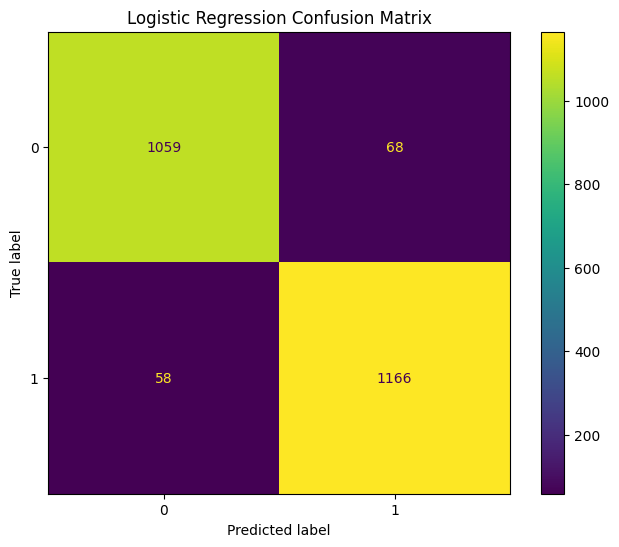

In [11]:
# Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
logreg_metrics = evaluate_model(logreg, X_train, X_test, y_train, y_test, "Logistic Regression")


Random Forest
Train Accuracy: 1.0000, Test Accuracy: 0.9413
Train ROC-AUC: 1.0000, Test ROC-AUC: 0.9869

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1127
           1       0.94      0.95      0.94      1224

    accuracy                           0.94      2351
   macro avg       0.94      0.94      0.94      2351
weighted avg       0.94      0.94      0.94      2351



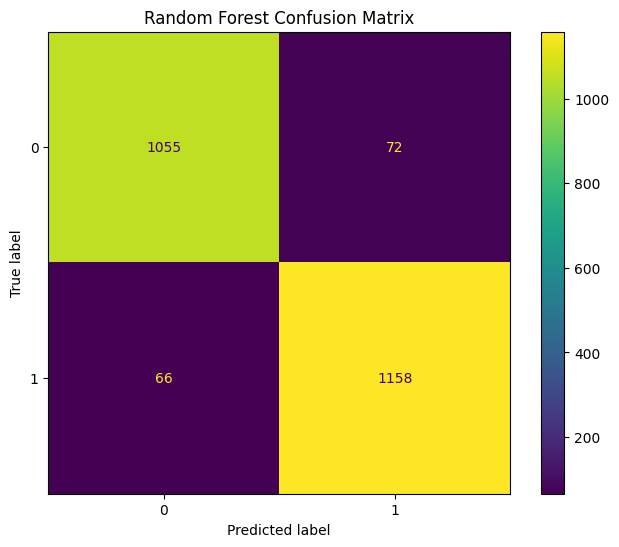

In [12]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_metrics = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")


XGBoost
Train Accuracy: 0.9757, Test Accuracy: 0.9426
Train ROC-AUC: 0.9977, Test ROC-AUC: 0.9882

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1127
           1       0.94      0.95      0.94      1224

    accuracy                           0.94      2351
   macro avg       0.94      0.94      0.94      2351
weighted avg       0.94      0.94      0.94      2351



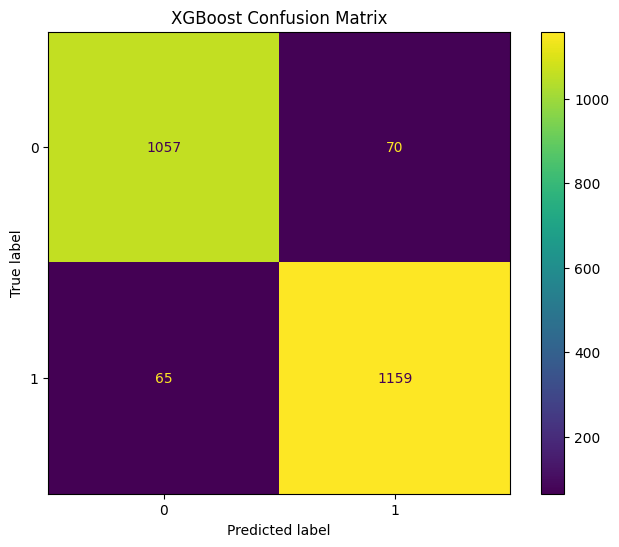

In [13]:
# T XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")


Naive Bayes
Train Accuracy: 0.8886, Test Accuracy: 0.8966
Train ROC-AUC: 0.9487, Test ROC-AUC: 0.9554

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1127
           1       0.88      0.92      0.90      1224

    accuracy                           0.90      2351
   macro avg       0.90      0.90      0.90      2351
weighted avg       0.90      0.90      0.90      2351



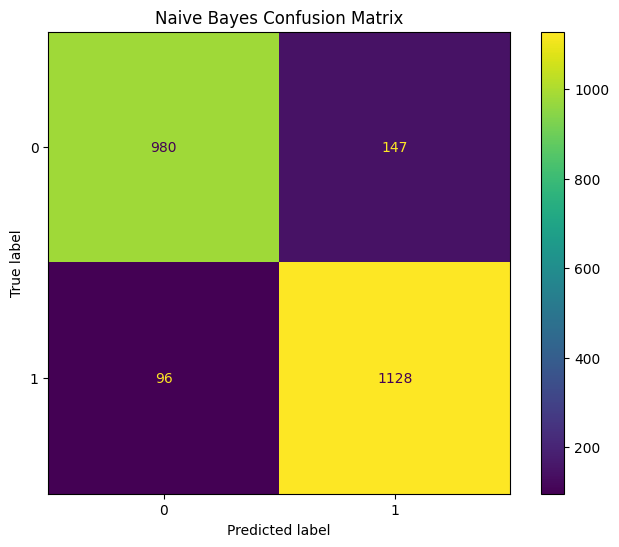

In [14]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_metrics = evaluate_model(nb, X_train, X_test, y_train, y_test, "Naive Bayes")


Support Vector Machine
Train Accuracy: 0.9515, Test Accuracy: 0.9464
Train ROC-AUC: 0.9885, Test ROC-AUC: 0.9892

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1127
           1       0.95      0.95      0.95      1224

    accuracy                           0.95      2351
   macro avg       0.95      0.95      0.95      2351
weighted avg       0.95      0.95      0.95      2351



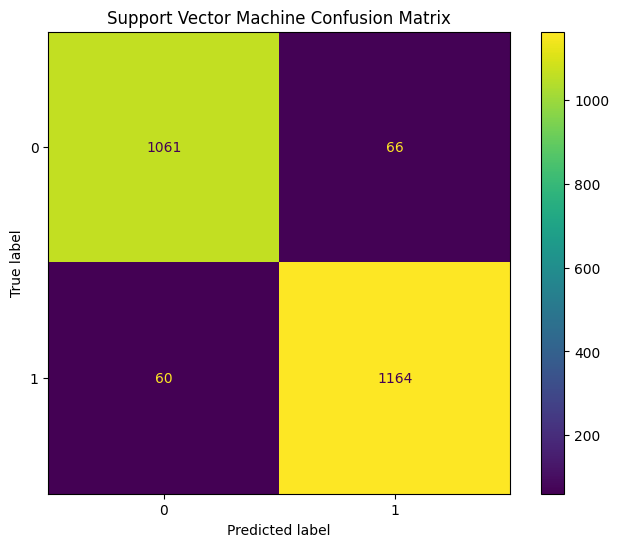

In [15]:
# Support Vector Machine
svm = SVC(probability=True, kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
svm_metrics = evaluate_model(svm, X_train, X_test, y_train, y_test, "Support Vector Machine")


K-Nearest Neighbors
Train Accuracy: 0.9544, Test Accuracy: 0.9426
Train ROC-AUC: 0.9929, Test ROC-AUC: 0.9760

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1127
           1       0.95      0.94      0.94      1224

    accuracy                           0.94      2351
   macro avg       0.94      0.94      0.94      2351
weighted avg       0.94      0.94      0.94      2351



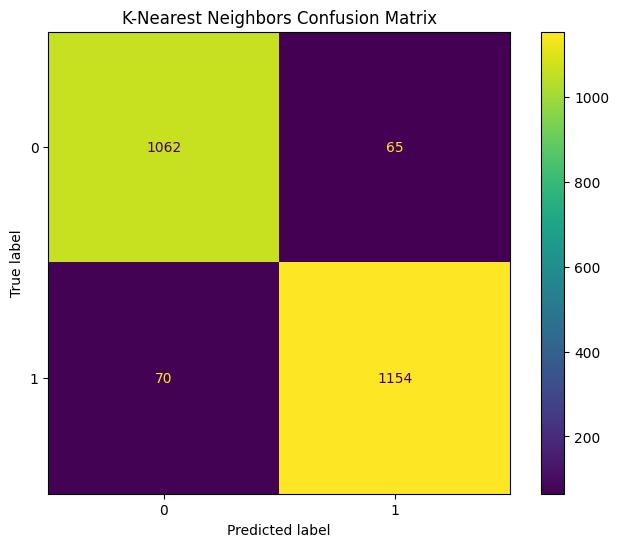

In [16]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_metrics = evaluate_model(knn, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")

In [17]:
# Compare models and select the best one
# Combine metrics into a single DataFrame
all_metrics = pd.DataFrame([logreg_metrics, rf_metrics, xgb_metrics, nb_metrics, svm_metrics, knn_metrics])
display(all_metrics)

# Select the best model based on test accuracy
best_model_idx = all_metrics["test_accuracy"].idxmax()
best_model_name = all_metrics.loc[best_model_idx, "model"]

if best_model_name == "Logistic Regression":
    best_model = logreg
elif best_model_name == "Random Forest":
    best_model = rf
elif best_model_name == "Naive Bayes":
    best_model = nb
elif best_model_name == "Support Vector Machine":
    best_model = svm
elif best_model_name == "K-Nearest Neighbors":
    best_model = knn

print(f"Best model: {best_model_name} with test accuracy {all_metrics.loc[best_model_idx, 'test_accuracy']:.4f}")

,model,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
0,Logistic Regression,0.949845,0.946406,0.987316,0.988645
1,Random Forest,1.000000,0.941302,1.000000,0.986934
2,XGBoost,0.975743,0.942578,0.997708,0.988201
3,Naive Bayes,0.888565,0.896640,0.948729,0.955409
4,Support Vector Machine,0.951486,0.946406,0.988451,0.989236
5,K-Nearest Neighbors,0.954405,0.942578,0.992918,0.976018


Best model: Logistic Regression with test accuracy 0.9464


In [18]:
# Train and evaluate baseline models for comparison
def compare_with_baselines():
    print("\n Baseline Model Comparison \n")
    
    # Baseline 1: Just gold difference
    X_gold_only = X_train[[f'golddiffat{used_minute}']]
    X_test_gold = X_test[[f'golddiffat{used_minute}']]
    
    gold_model = LogisticRegression(random_state=42)
    gold_model.fit(X_gold_only, y_train)
    gold_acc = gold_model.score(X_test_gold, y_test)
    gold_auc = roc_auc_score(y_test, gold_model.predict_proba(X_test_gold)[:, 1])
    
    # Baseline 2: Gold + XP + CS differences
    core_cols = [col for col in [f'golddiffat{used_minute}', f'xpdiffat{used_minute}', f'csdiffat{used_minute}'] 
                 if col in X_train.columns]
    X_core = X_train[core_cols]
    X_test_core = X_test[core_cols]
    
    core_model = LogisticRegression(random_state=42)
    core_model.fit(X_core, y_train)
    core_acc = core_model.score(X_test_core, y_test)
    core_auc = roc_auc_score(y_test, core_model.predict_proba(X_test_core)[:, 1])
    
    # Get full model metrics for comparison
    full_acc = best_model.score(X_test, y_test)
    if hasattr(best_model, "predict_proba"):
        full_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    else:
        full_auc = roc_auc_score(y_test, best_model.predict(X_test))
    
    results = pd.DataFrame({
        'Model': ['Gold Diff Only', 'Core Diffs (Gold+XP+CS)', f'Full {best_model_name}'],
        'Accuracy': [gold_acc, core_acc, full_acc],
        'ROC-AUC': [gold_auc, core_auc, full_auc],
        'Feature Count': [1, len(core_cols), len(X_train.columns)]
    })
    
    display(results)
    
    # Calculate improvement percentages
    gold_to_full = ((full_acc - gold_acc) / gold_acc) * 100
    core_to_full = ((full_acc - core_acc) / core_acc) * 100
    
    print(f"\nFull model improves over gold-only baseline by {gold_to_full:.2f}%")
    print(f"Full model improves over core stats baseline by {core_to_full:.2f}%")
    
    return results


baseline_results = compare_with_baselines()


 Baseline Model Comparison 



,Model,Accuracy,ROC-AUC,Feature Count
0,Gold Diff Only,0.712888,0.778377,1
1,Core Diffs (Gold+XP+CS),0.758826,0.837864,3
2,Full Logistic Regression,0.946406,0.988645,19



Full model improves over gold-only baseline by 32.76%
Full model improves over core stats baseline by 24.72%


,Feature,Importance
3,teamkills,16.398538
4,teamdeaths,14.164806
0,golddiffat25,2.014217
7,barons,1.374748
1,xpdiffat25,0.888537
8,opp_barons,0.422952
15,firstblood,0.304713
2,csdiffat25,0.298270
6,opp_dragons,0.000000
9,void_grubs,0.000000


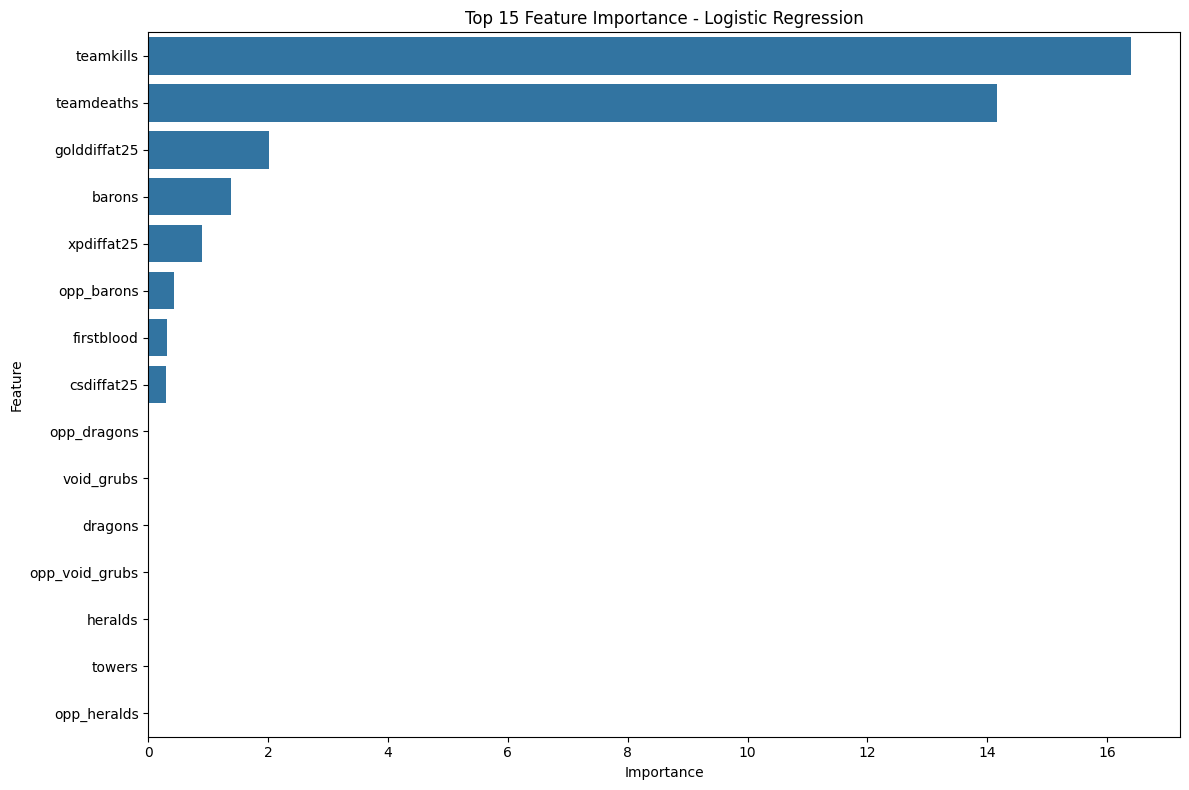

In [19]:
# Extract feature importances from the selected model

trained_features = X_train.columns

# Calculate feature importance based on model type
if best_model_name == "Logistic Regression":
    importances = np.abs(best_model.coef_[0])
elif best_model_name == "Support Vector Machine" and best_model.kernel == 'linear':
    # Only linear SVM has interpretable coefficients
    importances = np.abs(best_model.coef_[0])
elif best_model_name == "Naive Bayes":
    # For Naive Bayes use variance times coefficient as importance
    importances = np.abs(best_model.var_ * np.square(best_model.theta_[1] - best_model.theta_[0]))
elif best_model_name == "K-Nearest Neighbors":
    # KNN doesn't have native feature importance, so use permutation importance
    from sklearn.inspection import permutation_importance
    result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    importances = result.importances_mean
else:
    # Random Forest and XGBoost have feature_importances_
    importances = best_model.feature_importances_

# Create a DataFrame to display sorted feature importance
feature_importance = pd.DataFrame({
    "Feature": trained_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)


display(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
plt.title(f"Top 15 Feature Importance - {best_model_name}")
plt.tight_layout()
plt.show()


,Category,Avg Importance
1,Combat,15.281672
0,Gold/XP/CS Diff,1.067008
2,Objectives,0.179770
3,First Objectives,0.076178


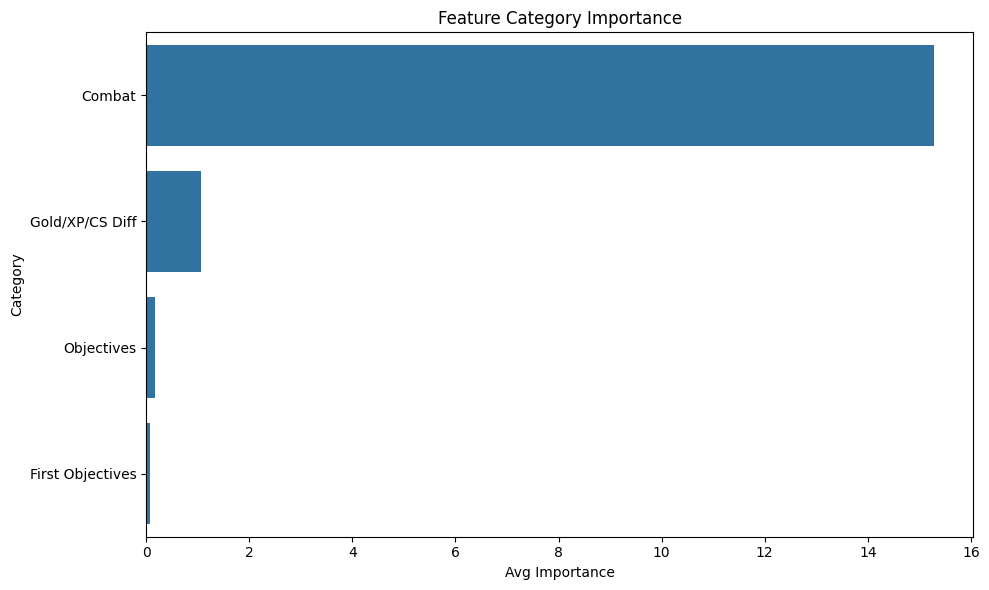

In [20]:
# Group features by category to analyze which types are most important

feature_categories = {
    "Gold/XP/CS Diff": [f"golddiffat{used_minute}", f"xpdiffat{used_minute}", f"csdiffat{used_minute}"],
    "Combat": ["teamkills", "teamdeaths"],
    "Objectives": ["dragons", "opp_dragons", "barons", "opp_barons", "heralds", "opp_heralds", "towers", "opp_towers", "void_grubs", "opp_void_grubs"],
    "First Objectives": ["firstblood", "firstdragon", "firstherald", "firsttower"]
}

# Calculate average importance per category
category_data = []
for category, features in feature_categories.items():
    relevant_features = [f for f in features if f in feature_importance["Feature"].values]
    if relevant_features:
        avg_importance = feature_importance[feature_importance["Feature"].isin(relevant_features)]["Importance"].mean()
        category_data.append((category, avg_importance))

# Create summary DataFrame and plot
category_df = pd.DataFrame(category_data, columns=["Category", "Avg Importance"]).sort_values("Avg Importance", ascending=False)
display(category_df)

plt.figure(figsize=(10, 6))
sns.barplot(x="Avg Importance", y="Category", data=category_df)
plt.title("Feature Category Importance")
plt.tight_layout()
plt.show()

In [21]:
# Function to predict blue team win probability from raw game stats
def predict_win(stats_dict, trained_model=best_model, original_scale=True):

    input_df = pd.DataFrame([stats_dict])
    
    # Apply scaling if needed
    if original_scale:
        scale_cols = [col for col in input_df.columns if col in valid_continuous_cols]
        if scale_cols:
            input_df[scale_cols] = scaler.transform(input_df[scale_cols])

    # Ensure all required columns are present
    for col in trained_features:
        if col not in input_df.columns:
            input_df[col] = 0

    input_df = input_df[trained_features]
    
    # Predict probability
    if hasattr(trained_model, "predict_proba"):
        prob = trained_model.predict_proba(input_df)[0][1]
    else:
        prob = trained_model.predict(input_df)[0]

    return prob


In [22]:
# Classify games as "close", "advantage", or "stomp" based on raw stats
def classify_game_state(game_row, used_minute=used_minute):
    gold_diff = game_row.get(f"golddiffat{used_minute}", 0)
    xp_diff = game_row.get(f"xpdiffat{used_minute}", 0)
    kill_diff = game_row.get("teamkills", 0) - game_row.get("teamdeaths", 0)
    obj_diff = (
        game_row.get("dragons", 0) - game_row.get("opp_dragons", 0) +
        game_row.get("towers", 0) - game_row.get("opp_towers", 0)
    )

    advantage_score = (
        abs(gold_diff) / 1500 +
        abs(xp_diff) / 1500 +
        abs(kill_diff) / 3 +
        abs(obj_diff)
    )

    blue_advantage = sum([
        gold_diff > 0,
        xp_diff > 0,
        kill_diff > 0,
        obj_diff > 0
    ]) >= 2

    advantaged_team = "Blue" if blue_advantage else "Red"

    if advantage_score < 2:
        return "close", "even"
    elif advantage_score < 5:
        return "advantage", advantaged_team
    else:
        return "stomp", advantaged_team


Accuracy by game state:


state
advantage    0.930857
close        0.651007
stomp        0.994323
Name: correct, dtype: float64


How often prediction follows advantaged team:


state
advantage    0.766770
close        0.000000
stomp        0.870235
Name: pred_follows_advantage, dtype: float64

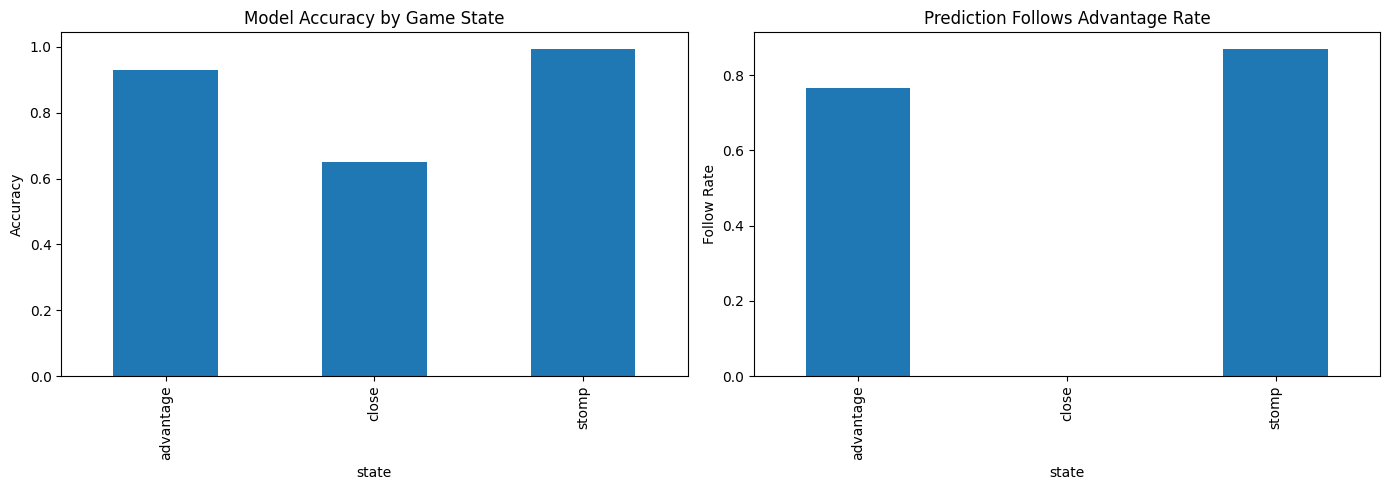

Found 149 close games, 969 advantage games, and 1233 stomp games.


In [23]:
# Apply classification and collect prediction behavior by game state

game_states = []

for idx in X_test_unscaled.index:
    game_row = X_test_unscaled.loc[idx]
    state, team = classify_game_state(game_row)
    prediction = predict_win(X_test.loc[idx].to_dict(), original_scale=False)
    actual = y_test.loc[idx]

    game_states.append({
        'index': idx,
        'state': state,
        'advantaged_team': team,
        'prediction': prediction,
        'actual': actual,
        'correct': (prediction > 0.5 and actual == 1) or (prediction < 0.5 and actual == 0)
    })

state_df = pd.DataFrame(game_states).set_index("index")

# Add columns for analysis
state_df['pred_blue'] = state_df['prediction'] > 0.5
state_df['pred_follows_advantage'] = (
    (state_df['advantaged_team'] == 'Blue') & (state_df['pred_blue']) |
    (state_df['advantaged_team'] == 'Red') & (~state_df['pred_blue'])
)

# Accuracy metrics
accuracy_by_state = state_df.groupby('state')['correct'].mean()
follow_rate = state_df.groupby('state')['pred_follows_advantage'].mean()

print("Accuracy by game state:")
display(accuracy_by_state)

print("\nHow often prediction follows advantaged team:")
display(follow_rate)

# Plot 
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
accuracy_by_state.plot(kind='bar', ax=axs[0], title="Model Accuracy by Game State")
axs[0].set_ylabel("Accuracy")
follow_rate.plot(kind='bar', ax=axs[1], title="Prediction Follows Advantage Rate")
axs[1].set_ylabel("Follow Rate")
plt.tight_layout()
plt.show()

# Save index sets
close_state_games = state_df[state_df["state"] == "close"].index
advantage_state_games = state_df[state_df["state"] == "advantage"].index
stomp_state_games = state_df[state_df["state"] == "stomp"].index

print(f"Found {len(close_state_games)} close games, {len(advantage_state_games)} advantage games, and {len(stomp_state_games)} stomp games.")


In [24]:
# Analyze predictions on individual games of a given type
def analyze_games(game_indices, label="Close"):
    print(f"\nAnalyzing {label} games:")
    print(f"Total games: {len(game_indices)}")

    results = []

    for i, idx in enumerate(game_indices[:5]):
        unscaled_game = X_test_unscaled.loc[idx]
        scaled_game = X_test.loc[idx]
        prob = predict_win(scaled_game.to_dict(), original_scale=False)
        actual = y_test.loc[idx]

        print(f"\n Game {i+1} — Predicted: {prob * 100:.2f}%, Actual: {'Blue win' if actual else 'Red win'}")

        key_stats = {}
        for stat in [
            f"golddiffat{used_minute}", f"xpdiffat{used_minute}",
            f"csdiffat{used_minute}", "teamkills", "teamdeaths"
        ]:
            if stat in unscaled_game:
                value = unscaled_game[stat]
                print(f"  {stat}: {value:.2f}")
                key_stats[stat] = value

        results.append({
            "game_type": label,
            "prediction": prob,
            "actual": actual,
            "correct": (prob > 0.5 and actual == 1) or (prob < 0.5 and actual == 0),
            **key_stats
        })

    return results

In [25]:
# Prediction performance on close and stomp games
close_results = analyze_games(close_state_games, "Close")
stomp_results = analyze_games(stomp_state_games, "Stomp")

# Compute accuracy
if close_results:
    close_acc = sum(r["correct"] for r in close_results) / len(close_results)
    print(f"\nAccuracy on close games: {close_acc:.2%}")

if stomp_results:
    stomp_acc = sum(r["correct"] for r in stomp_results) / len(stomp_results)
    print(f"Accuracy on stomp games: {stomp_acc:.2%}")

def report_correctness(results, label):
    correct = sum(r["correct"] for r in results)
    total = len(results)
    print(f"{label}: {correct}/{total} correct — Accuracy: {correct / total:.2%}")
    print("Sample predictions:")
    for r in results[:3]:
        print(f"  - Pred: {r['prediction']:.2f}, Actual: {r['actual']}, Correct: {r['correct']}")

report_correctness(close_results, "Close Games")
report_correctness(stomp_results, "Stomp Games")




Analyzing Close games:
Total games: 149

 Game 1 — Predicted: 40.02%, Actual: Blue win
  golddiffat25: -1071.00
  xpdiffat25: -465.00
  csdiffat25: -63.00
  teamkills: 24.00
  teamdeaths: 24.00

 Game 2 — Predicted: 59.23%, Actual: Red win
  golddiffat25: -390.00
  xpdiffat25: -334.00
  csdiffat25: -23.00
  teamkills: 13.00
  teamdeaths: 12.00

 Game 3 — Predicted: 49.53%, Actual: Blue win
  golddiffat25: -669.00
  xpdiffat25: -635.00
  csdiffat25: 2.00
  teamkills: 15.00
  teamdeaths: 15.00

 Game 4 — Predicted: 72.09%, Actual: Blue win
  golddiffat25: 748.00
  xpdiffat25: 139.00
  csdiffat25: -25.00
  teamkills: 20.00
  teamdeaths: 17.00

 Game 5 — Predicted: 62.94%, Actual: Red win
  golddiffat25: 326.00
  xpdiffat25: 1222.00
  csdiffat25: -33.00
  teamkills: 24.00
  teamdeaths: 22.00

Analyzing Stomp games:
Total games: 1233

 Game 1 — Predicted: 0.95%, Actual: Red win
  golddiffat25: -856.00
  xpdiffat25: -1026.00
  csdiffat25: -49.00
  teamkills: 22.00
  teamdeaths: 35.00

 Game


Model accuracy by gold difference:
< -5000: 100.00% accuracy (26 games)
-5000 to -2500: 95.65% accuracy (230 games)
-2500 to -1000: 96.01% accuracy (451 games)
-1000 to 0: 93.57% accuracy (451 games)
0 to 1000: 93.21% accuracy (442 games)
1000 to 2500: 94.16% accuracy (497 games)
2500 to 5000: 95.95% accuracy (222 games)
> 5000: 96.88% accuracy (32 games)


C:\Users\Jayden\AppData\Local\Temp\ipykernel_8500\2184135431.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_bin = analysis_df.groupby('gold_diff_bin')['correct'].mean()
C:\Users\Jayden\AppData\Local\Temp\ipykernel_8500\2184135431.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = analysis_df.groupby('gold_diff_bin').size()


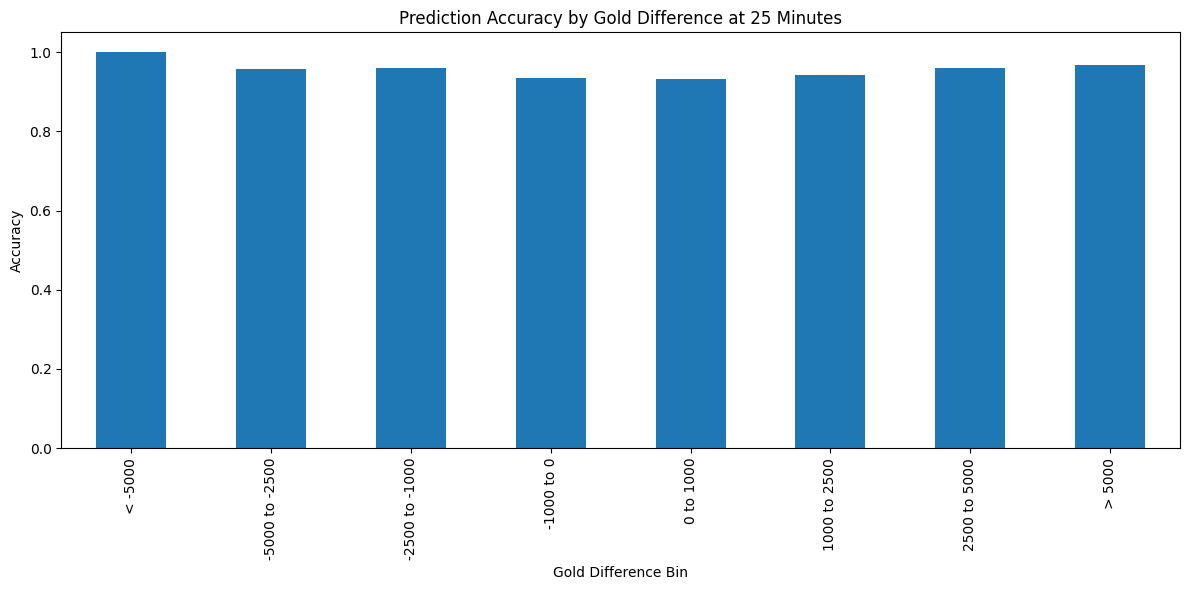

In [26]:
# Create gold difference bins and evaluate prediction accuracy within each bin
bins = [-float('inf'), -5000, -2500, -1000, 0, 1000, 2500, 5000, float('inf')]
labels = ['< -5000', '-5000 to -2500', '-2500 to -1000', '-1000 to 0', 
          '0 to 1000', '1000 to 2500', '2500 to 5000', '> 5000']

analysis_df = pd.DataFrame({
    'gold_diff': X_test_unscaled[f'golddiffat{used_minute}'],
    'actual': y_test,
    'gold_diff_bin': pd.cut(X_test_unscaled[f'golddiffat{used_minute}'], bins=bins, labels=labels)
})

# Add predictions and correctness
analysis_df['prediction'] = analysis_df.index.map(
    lambda idx: predict_win(X_test.loc[idx].to_dict(), original_scale=False)
)
analysis_df['predicted_win'] = analysis_df['prediction'] > 0.5
analysis_df['correct'] = analysis_df['predicted_win'] == analysis_df['actual']

# Calculate accuracy per bin
accuracy_by_bin = analysis_df.groupby('gold_diff_bin')['correct'].mean()
counts_by_bin = analysis_df.groupby('gold_diff_bin').size()

# Display result per bin
print("\nModel accuracy by gold difference:")
for bin_label in labels:
    if bin_label in accuracy_by_bin:
        acc = accuracy_by_bin[bin_label]
        count = counts_by_bin[bin_label]
        print(f"{bin_label}: {acc:.2%} accuracy ({count} games)")

plt.figure(figsize=(12, 6))
accuracy_by_bin.plot(kind='bar')
plt.title(f"Prediction Accuracy by Gold Difference at {used_minute} Minutes")
plt.ylabel("Accuracy")
plt.xlabel("Gold Difference Bin")
plt.tight_layout()
plt.show()


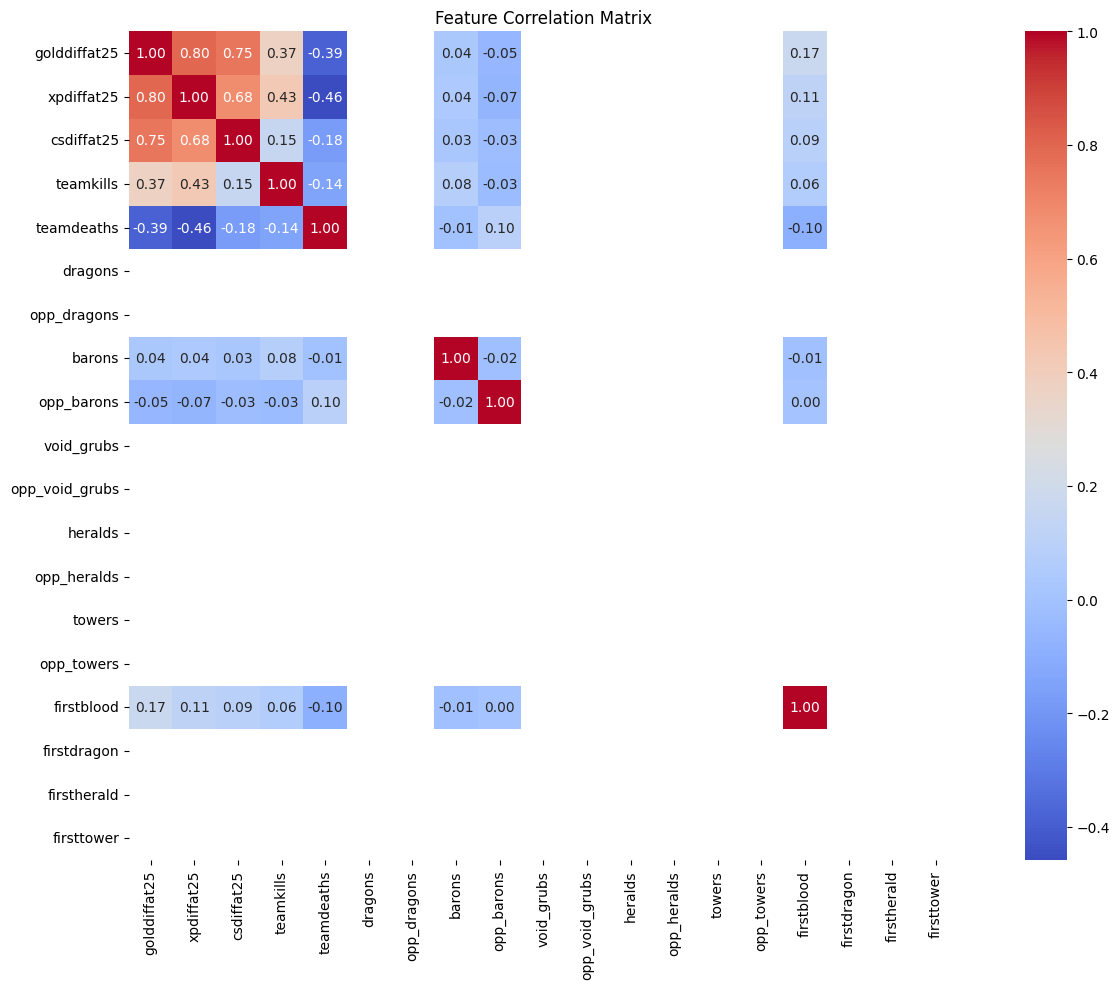

In [27]:
# Compute correlation between all unscaled features
corr_matrix = X_unscaled.corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [28]:
# Add the result column to X for correlation
X_with_result = X_unscaled.copy()
X_with_result["result"] = y_filtered.values

# Compute correlation of each feature with the result
corr_table = X_with_result.corr()

# Show correlation with result only
print("Correlation of features with game result:\n")
display(corr_table["result"].sort_values(ascending=False))


Correlation of features with game result:



result            1.000000
teamkills         0.629587
xpdiffat25        0.514905
golddiffat25      0.459866
csdiffat25        0.234229
barons            0.069215
firstblood        0.069092
opp_barons       -0.085386
teamdeaths       -0.665662
dragons                NaN
opp_dragons            NaN
void_grubs             NaN
opp_void_grubs         NaN
heralds                NaN
opp_heralds            NaN
towers                 NaN
opp_towers             NaN
firstdragon            NaN
firstherald            NaN
firsttower             NaN
Name: result, dtype: float64

In [29]:
def predict_win(stats_dict, trained_model=best_model, original_scale=True):

    # Create input DataFrame with all required features, initialized to 0
    input_df = pd.DataFrame(0, index=[0], columns=trained_features)
    
    # Fill in provided values
    for col in stats_dict:
        if col in input_df.columns:
            input_df[col] = stats_dict[col]
    
    # Scale if needed
    if original_scale:
        # Only scale continuous features
        continuous_cols = [col for col in valid_continuous_cols if col in trained_features]
        if continuous_cols:
            input_df[continuous_cols] = scaler.transform(input_df[continuous_cols])
    
    # Get win probability
    if hasattr(trained_model, "predict_proba"):
        prob = trained_model.predict_proba(input_df)[0][1]
    else:
        prob = trained_model.predict(input_df)[0]

    return prob

In [30]:
def demo():
    # Define scenarios
    scenarios = [
        {
            "name": "Blue Team Advantage",
            "stats": {
                f"golddiffat{used_minute}": 2500,
                f"xpdiffat{used_minute}": 1800,
                f"csdiffat{used_minute}": 15,
                "teamkills": 10,
                "teamdeaths": 5,
                "dragons": 2,
                "opp_dragons": 0,
                "towers": 3,
                "opp_towers": 1,
                "firstblood": 1,
                "firstdragon": 1,
                "firsttower": 1
            }
        },
        {
            "name": "Even Game",
            "stats": {
                f"golddiffat{used_minute}": 200,
                f"xpdiffat{used_minute}": -150,
                f"csdiffat{used_minute}": 5,
                "teamkills": 6,
                "teamdeaths": 6,
                "dragons": 1,
                "opp_dragons": 1,
                "towers": 2,
                "opp_towers": 2,
                "firstblood": 1,
                "firstdragon": 0,
                "firsttower": 0
            }
        },
        {
            "name": "Red Team Advantage",
            "stats": {
                f"golddiffat{used_minute}": -2800,
                f"xpdiffat{used_minute}": -2000,
                f"csdiffat{used_minute}": -20,
                "teamkills": 3,
                "teamdeaths": 9,
                "dragons": 0,
                "opp_dragons": 2,
                "towers": 1,
                "opp_towers": 3,
                "firstblood": 0,
                "firstdragon": 0,
                "firsttower": 0
            }
        }
    ]
    
    print(f"  LEAGUE OF LEGENDS WIN PREDICTOR DEMO - {best_model_name} MODEL")
    
    
    
    for scenario in scenarios:
        # Only include features that are in our model
        filtered_stats = {k: v for k, v in scenario["stats"].items() if k in trained_features}
        win_prob = predict_win(filtered_stats)
        
        print(f"\n--- {scenario['name']} ---")
        print(f"Key stats:")
        for key in [f"golddiffat{used_minute}", f"xpdiffat{used_minute}", "teamkills", "teamdeaths"]:
            if key in filtered_stats:
                print(f"  {key}: {filtered_stats[key]}")
        
        print(f"Blue Team Win Probability: {win_prob:.2%}")
        
        # Show what the model would be classified as
        if win_prob > 0.5:
            print("Prediction: Blue win")
        else:
            print("Prediction: Red win")
            
        # Show confidence
        confidence = max(win_prob, 1-win_prob)
        print(f"Confidence: {confidence:.2%}")
        
demo()


  LEAGUE OF LEGENDS WIN PREDICTOR DEMO - Logistic Regression MODEL

--- Blue Team Advantage ---
Key stats:
  golddiffat25: 2500
  xpdiffat25: 1800
  teamkills: 10
  teamdeaths: 5
Blue Team Win Probability: 87.35%
Prediction: Blue win
Confidence: 87.35%

--- Even Game ---
Key stats:
  golddiffat25: 200
  xpdiffat25: -150
  teamkills: 6
  teamdeaths: 6
Blue Team Win Probability: 52.22%
Prediction: Blue win
Confidence: 52.22%

--- Red Team Advantage ---
Key stats:
  golddiffat25: -2800
  xpdiffat25: -2000
  teamkills: 3
  teamdeaths: 9
Blue Team Win Probability: 13.18%
Prediction: Red win
Confidence: 86.82%


In [31]:
# Move demo to file for readability
def quick_demo_to_file(filename="quick_demo_output.txt"):
    with open(filename, "w") as f:
        original_stdout = sys.stdout
        sys.stdout = f  # Redirect print output to file
        
        demo()
        
        sys.stdout = original_stdout  # Restore original behavior

quick_demo_to_file()

In [32]:
# Summary 
print(f"""
## Summary of League of Legends Win Prediction Analysis

- **Data checkpoint used**: {used_minute} minutes
- **Best performing model**: {best_model_name} with {all_metrics.loc[best_model_idx, 'test_accuracy']:.2%} accuracy
- **Most important features**: {', '.join(feature_importance['Feature'].iloc[:3].tolist())}
- **Most predictive category**: {category_df['Category'].iloc[0]} with {category_df['Avg Importance'].iloc[0]:.4f} importance score

### Key Insights:
1. Gold difference at {used_minute} minutes is highly predictive of game outcome
2. The model performs {'better' if stomp_acc > close_acc else 'worse'} on stomp games compared to close games
3. Objective control metrics are {'important' if 'Objectives' in category_df['Category'].values and category_df.loc[category_df['Category'] == 'Objectives', 'Avg Importance'].iloc[0] > 0.1 else 'less important than expected'}
""")

# Analysis Recommendations:
print("""
### Recommendations for Further Analysis:
1. Examine how prediction accuracy varies by game duration
2. Analyze if specific team compositions affect prediction accuracy
3. Consider adding champion-specific features for more nuanced predictions
4. Create a time-series analysis showing how prediction confidence changes throughout the game
""")


## Summary of League of Legends Win Prediction Analysis

- **Data checkpoint used**: 25 minutes
- **Best performing model**: Logistic Regression with 94.64% accuracy
- **Most important features**: teamkills, teamdeaths, golddiffat25
- **Most predictive category**: Combat with 15.2817 importance score

### Key Insights:
1. Gold difference at 25 minutes is highly predictive of game outcome
2. The model performs better on stomp games compared to close games
3. Objective control metrics are important


### Recommendations for Further Analysis:
1. Examine how prediction accuracy varies by game duration
2. Analyze if specific team compositions affect prediction accuracy
3. Consider adding champion-specific features for more nuanced predictions
4. Create a time-series analysis showing how prediction confidence changes throughout the game

